<a href="https://colab.research.google.com/github/kjmobile/B735/blob/main/1_Face_Recognition_PCA%26SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

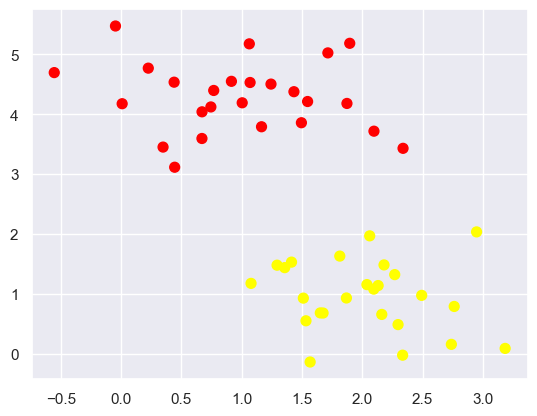

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [ ]:
# from sklearn.datasets.samples_generator import make_blobs
# X, y = make_blobs(n_samples=50, centers=2,
#                   random_state=0, cluster_std=0.60)
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

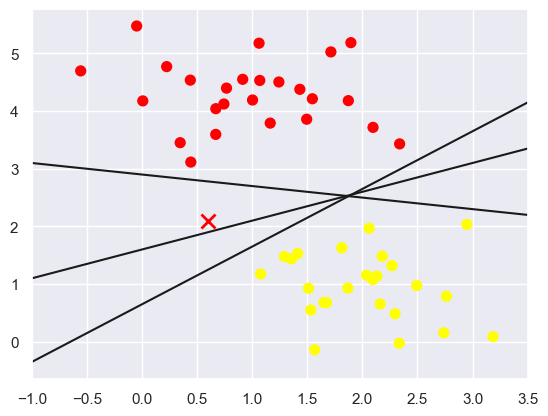

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Face Recognition - USING SVM & PCA

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)
print(faces.data)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
[[0.53333336 0.52418303 0.49673203 ... 0.00653595 0.00653595 0.00130719]
 [0.28627452 0.20784314 0.2535948  ... 0.96993464 0.95032686 0.9346406 ]
 [0.31633988 0.3895425  0.275817   ... 0.4261438  0.7895425  0.9555555 ]
 ...
 [0.11633987 0.11111111 0.10196079 ... 0.5660131  0.579085   0.5542484 ]
 [0.19346406 0.21045752 0.29150328 ... 0.6875817  0.6575164  0.5908497 ]
 [0.12418301 0.09673203 0.10849673 ... 0.12941177 0.16209151 0.29150328]]


In [ ]:
faces.images.shape # image in 3 (samples, height, width) dimensional array

(1348, 62, 47)

Let's plot a few of these faces to see what we're working with:

In [ ]:
faces.data # images as flattened vectors

array([[0.53333336, 0.52418303, 0.49673203, ..., 0.00653595, 0.00653595,
        0.00130719],
       [0.28627452, 0.20784314, 0.2535948 , ..., 0.96993464, 0.95032686,
        0.9346406 ],
       [0.31633988, 0.3895425 , 0.275817  , ..., 0.4261438 , 0.7895425 ,
        0.9555555 ],
       ...,
       [0.11633987, 0.11111111, 0.10196079, ..., 0.5660131 , 0.579085  ,
        0.5542484 ],
       [0.19346406, 0.21045752, 0.29150328, ..., 0.6875817 , 0.6575164 ,
        0.5908497 ],
       [0.12418301, 0.09673203, 0.10849673, ..., 0.12941177, 0.16209151,
        0.29150328]], dtype=float32)

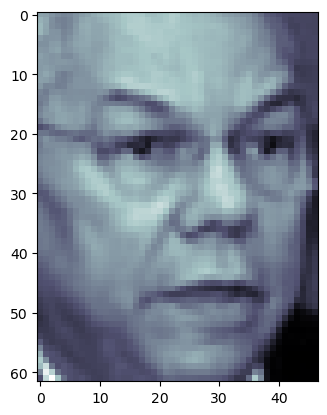

In [ ]:
plt.imshow(faces.images[0], cmap='bone')
plt.show()

In [ ]:
faces.target

array([1, 3, 3, ..., 7, 3, 5], dtype=int64)

In [ ]:
faces.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

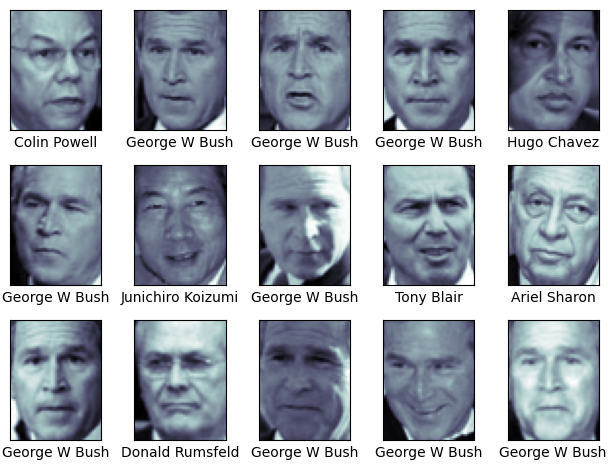

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
plt.tight_layout()
plt.show()

# Demension reduction by PCA prior to applying SVM

Each image contains [62×47] or 2914 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; <br>here we will use a **principal component analysis** to extract 150 fundamental components to feed into our support vector machine classifier.
<br>We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [ ]:
from sklearn.svm import SVC    # Q1 through Q5
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]} #Q6 ~ Q7
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 27.3 s
Wall time: 40.5 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

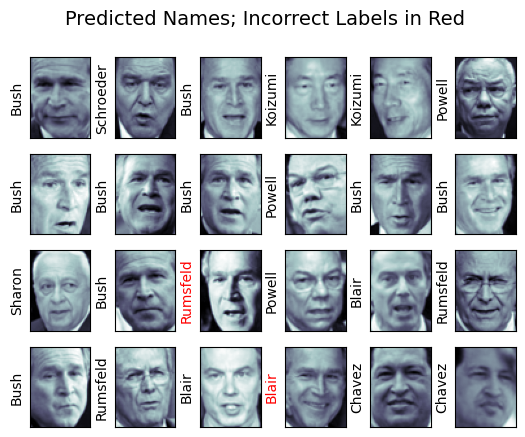

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

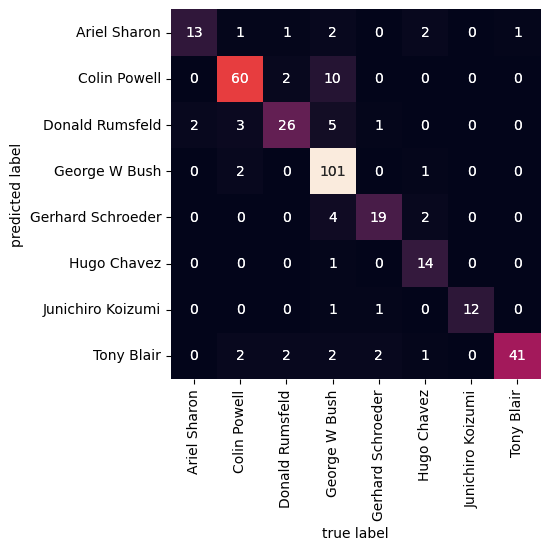

In [ ]:
from sklearn.metrics import confusion_matrix  #Q8
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
